# Semantic Segmentation for Autonomous Vehicles using CamVid dataset

## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import re
from PIL import Image


import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import os
import sys
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *


#from tensorflow.keras.engine import Layer
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.models import *
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D
from tensorflow.keras.layers import Input, Add, Dropout, Permute, add
from tensorflow.compat.v1.layers import conv2d_transpose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## Environment checks

In [2]:
print(tf.__version__)

2.0.0-alpha0


In [3]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.test.is_gpu_available())

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

print("Device name: {}".format((x.device)))

Is there a GPU available: 
True
Is the Tensor on GPU #0:  
True
Device name: /job:localhost/replica:0/task:0/device:GPU:0


In [4]:
print(tf.executing_eagerly())

True


## Data preparation - Importing, Cleaning and Creating structured directory 

### Function to import and process frames and masks as tensors

In [5]:
def _read_to_tensor(fname, output_height=256, output_width=256, normalize_data=False):
    '''Function to read images from given image file path, and provide resized images as tensors
        Inputs: 
            fname - image file path
            output_height - required output image height
            output_width - required output image width
            normalize_data - if True, normalize data to be centered around 0 (mean 0, range 0 to 1)
        Output: Processed image tensors
    '''
    
    # Read the image as a tensor
    img_strings = tf.io.read_file(fname)
    imgs_decoded = tf.image.decode_jpeg(img_strings)
    
    # Resize the image
    output = tf.image.resize(imgs_decoded, [output_height, output_width])
    
    # Normalize if required
    if normalize_data:
        output = (output - 128) / 128
    return output

### Image directory and size parameters

In [6]:
img_dir = 'data/CamSeq01/'

# Required image dimensions
output_height = 256
output_width = 256

### Reading frames and masks
- Mask file names end in "\_L.png"


In [7]:
def read_images(img_dir):
    '''Function to get all image directories, read images and masks in separate tensors
        Inputs: 
            img_dir - file directory
        Outputs 
            frame_tensors, masks_tensors, frame files list, mask files list
    '''
    
    # Get the file names list from provided directory
    file_list = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
    
    # Separate frame and mask files lists, exclude unnecessary files
    frames_list = [file for file in file_list if ('_L' not in file) and ('txt' not in file)]
    masks_list = [file for file in file_list if ('_L' in file) and ('txt' not in file)]
    
    print('{} frame files found in the provided directory.'.format(len(frames_list)))
    print('{} mask files found in the provided directory.'.format(len(masks_list)))
    
    # Create file paths from file names
    frames_paths = [os.path.join(img_dir, fname) for fname in frames_list]
    masks_paths = [os.path.join(img_dir, fname) for fname in masks_list]
    
    # Create dataset of tensors
    frame_data = tf.data.Dataset.from_tensor_slices(frames_paths)
    masks_data = tf.data.Dataset.from_tensor_slices(masks_paths)
    
    # Read images into the tensor dataset
    frame_tensors = frame_data.map(_read_to_tensor)
    masks_tensors = masks_data.map(_read_to_tensor)
    
    print('Completed importing {} frame images from the provided directory.'.format(len(frames_list)))
    print('Completed importing {} mask images from the provided directory.'.format(len(masks_list)))
    
    return frame_tensors, masks_tensors, frames_list, masks_list

frame_tensors, masks_tensors, frames_list, masks_list = read_images(img_dir)

100 frame files found in the provided directory.
100 mask files found in the provided directory.
Completed importing 100 frame images from the provided directory.
Completed importing 100 mask images from the provided directory.


### Displaying Images in the train dataset

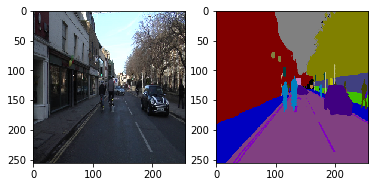

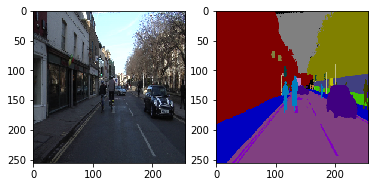

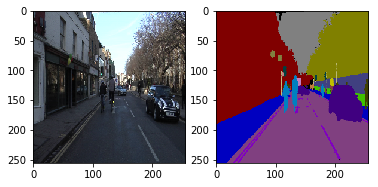

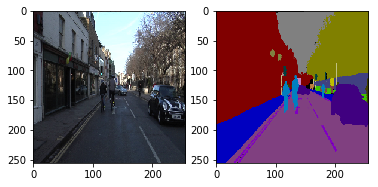

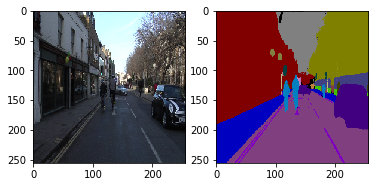

In [8]:
# Make an iterator to extract images from the tensor dataset
frame_batches = tf.compat.v1.data.make_one_shot_iterator(frame_tensors)  # outside of TF Eager, we would use make_one_shot_iterator
mask_batches = tf.compat.v1.data.make_one_shot_iterator(masks_tensors)

n_images_to_show = 5

for i in range(n_images_to_show):
    
    # Get the next image from iterator
    frame = frame_batches.next().numpy().astype(np.uint8)
    mask = mask_batches.next().numpy().astype(np.uint8)
    
    #Plot the corresponding frames and masks
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(frame)
    fig.add_subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

### Creating folder structure common for Computer Vision problems

In [9]:
DATA_PATH = 'data/CamSeq01/'

# Create folders to hold images and masks

folders = ['train_frames/train', 'train_masks/train', 'val_frames/val', 'val_masks/val']


for folder in folders:
    try:
        os.makedirs(DATA_PATH + folder)
    except Exception as e: print(e)

[WinError 183] Cannot create a file when that file already exists: 'data/CamSeq01/train_frames/train'
[WinError 183] Cannot create a file when that file already exists: 'data/CamSeq01/train_masks/train'
[WinError 183] Cannot create a file when that file already exists: 'data/CamSeq01/val_frames/val'
[WinError 183] Cannot create a file when that file already exists: 'data/CamSeq01/val_masks/val'


### Saving frames and masks to correct directories

In [10]:
def generate_image_folder_structure(frames, masks, frames_list, masks_list):
    '''Function to save images in the appropriate folder directories 
        Inputs: 
            frames - frame tensor dataset
            masks - mask tensor dataset
            frames_list - frame file paths
            masks_list - mask file paths
    '''
    #Create iterators for frames and masks
    frame_batches = tf.compat.v1.data.make_one_shot_iterator(frames)  # outside of TF Eager, we would use make_one_shot_iterator
    mask_batches = tf.compat.v1.data.make_one_shot_iterator(masks)
    
    #Iterate over the train images while saving the frames and masks in appropriate folders
    dir_name='train'
    for file in zip(frames_list[:-round(0.2*len(frames_list))],masks_list[:-round(0.2*len(masks_list))]):
        
        
        #Convert tensors to numpy arrays
        frame = frame_batches.next().numpy().astype(np.uint8)
        mask = mask_batches.next().numpy().astype(np.uint8)
        
        #Convert numpy arrays to images
        frame = Image.fromarray(frame)
        mask = Image.fromarray(mask)
        
        #Save frames and masks to correct directories
        frame.save(DATA_PATH+'{}_frames/{}'.format(dir_name,dir_name)+'/'+file[0])
        mask.save(DATA_PATH+'{}_masks/{}'.format(dir_name,dir_name)+'/'+file[1])
    
    #Iterate over the val images while saving the frames and masks in appropriate folders
    dir_name='val'
    for file in zip(frames_list[-round(0.2*len(frames_list)):],masks_list[-round(0.2*len(masks_list)):]):
        
        
        #Convert tensors to numpy arrays
        frame = frame_batches.next().numpy().astype(np.uint8)
        mask = mask_batches.next().numpy().astype(np.uint8)
        
        #Convert numpy arrays to images
        frame = Image.fromarray(frame)
        mask = Image.fromarray(mask)
        
        #Save frames and masks to correct directories
        frame.save(DATA_PATH+'{}_frames/{}'.format(dir_name,dir_name)+'/'+file[0])
        mask.save(DATA_PATH+'{}_masks/{}'.format(dir_name,dir_name)+'/'+file[1])
    
    print("Saved {} frames to directory {}".format(len(frames_list),DATA_PATH))
    print("Saved {} masks to directory {}".format(len(masks_list),DATA_PATH))
    
generate_image_folder_structure(frame_tensors, masks_tensors, frames_list, masks_list)

#generate_image_folder_structure(train_frames, train_masks, val_files, 'val')

Saved 100 frames to directory data/CamSeq01/
Saved 100 masks to directory data/CamSeq01/


## Extract Target Class definitions

### Function to parse the file "label_colors.txt" which contains the class definitions

In [11]:
def parse_code(l):
    '''Function to parse lines in a text file, returns separated elements (label codes and names in this case)
    '''
    if len(l.strip().split("\t")) == 2:
        a, b = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), b
    else:
        a, b, c = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), c

### Parse and extract label names and codes

In [12]:
label_codes, label_names = zip(*[parse_code(l) for l in open(img_dir+"label_colors.txt")])
label_codes, label_names = list(label_codes), list(label_names)
label_codes[:5], label_names[:5]

([(64, 128, 64), (192, 0, 128), (0, 128, 192), (0, 128, 64), (128, 0, 0)],
 ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building'])

In [13]:
label_codes, label_names

([(64, 128, 64),
  (192, 0, 128),
  (0, 128, 192),
  (0, 128, 64),
  (128, 0, 0),
  (64, 0, 128),
  (64, 0, 192),
  (192, 128, 64),
  (192, 192, 128),
  (64, 64, 128),
  (128, 0, 192),
  (192, 0, 64),
  (128, 128, 64),
  (192, 0, 192),
  (128, 64, 64),
  (64, 192, 128),
  (64, 64, 0),
  (128, 64, 128),
  (128, 128, 192),
  (0, 0, 192),
  (192, 128, 128),
  (128, 128, 128),
  (64, 128, 192),
  (0, 0, 64),
  (0, 64, 64),
  (192, 64, 128),
  (128, 128, 0),
  (192, 128, 192),
  (64, 0, 64),
  (192, 192, 0),
  (0, 0, 0),
  (64, 192, 0)],
 ['Animal',
  'Archway',
  'Bicyclist',
  'Bridge',
  'Building',
  'Car',
  'CartLuggagePram',
  'Child',
  'Column_Pole',
  'Fence',
  'LaneMkgsDriv',
  'LaneMkgsNonDriv',
  'Misc_Text',
  'MotorcycleScooter',
  'OtherMoving',
  'ParkingBlock',
  'Pedestrian',
  'Road',
  'RoadShoulder',
  'Sidewalk',
  'SignSymbol',
  'Sky',
  'SUVPickupTruck',
  'TrafficCone',
  'TrafficLight',
  'Train',
  'Tree',
  'Truck_Bus',
  'Tunnel',
  'VegetationMisc',
  'Void'

### Create useful label and code conversion dictionaries
_These will be used for:_
- One hot encoding the mask labels for model training
- Decoding the predicted labels for interpretation and visualization

In [14]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

In [15]:
name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [16]:
id2code

{0: (64, 128, 64),
 1: (192, 0, 128),
 2: (0, 128, 192),
 3: (0, 128, 64),
 4: (128, 0, 0),
 5: (64, 0, 128),
 6: (64, 0, 192),
 7: (192, 128, 64),
 8: (192, 192, 128),
 9: (64, 64, 128),
 10: (128, 0, 192),
 11: (192, 0, 64),
 12: (128, 128, 64),
 13: (192, 0, 192),
 14: (128, 64, 64),
 15: (64, 192, 128),
 16: (64, 64, 0),
 17: (128, 64, 128),
 18: (128, 128, 192),
 19: (0, 0, 192),
 20: (192, 128, 128),
 21: (128, 128, 128),
 22: (64, 128, 192),
 23: (0, 0, 64),
 24: (0, 64, 64),
 25: (192, 64, 128),
 26: (128, 128, 0),
 27: (192, 128, 192),
 28: (64, 0, 64),
 29: (192, 192, 0),
 30: (0, 0, 0),
 31: (64, 192, 0)}

In [17]:
id2name

{0: 'Animal',
 1: 'Archway',
 2: 'Bicyclist',
 3: 'Bridge',
 4: 'Building',
 5: 'Car',
 6: 'CartLuggagePram',
 7: 'Child',
 8: 'Column_Pole',
 9: 'Fence',
 10: 'LaneMkgsDriv',
 11: 'LaneMkgsNonDriv',
 12: 'Misc_Text',
 13: 'MotorcycleScooter',
 14: 'OtherMoving',
 15: 'ParkingBlock',
 16: 'Pedestrian',
 17: 'Road',
 18: 'RoadShoulder',
 19: 'Sidewalk',
 20: 'SignSymbol',
 21: 'Sky',
 22: 'SUVPickupTruck',
 23: 'TrafficCone',
 24: 'TrafficLight',
 25: 'Train',
 26: 'Tree',
 27: 'Truck_Bus',
 28: 'Tunnel',
 29: 'VegetationMisc',
 30: 'Void',
 31: 'Wall'}

### Define functions for one hot encoding rgb labels, and decoding encoded predictions

In [18]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

# Creating custom Image data generators

### Defining data generators

In [19]:
# Normalizing only frame images, since masks contain label info
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)

# Seed defined for aligning images and their masks
seed = 1

### Custom image data generators for creating batches of frames and masks

In [20]:
def TrainAugmentGenerator(seed = 1, batch_size = 5):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    train_image_generator = train_frames_datagen.flow_from_directory(
    DATA_PATH + 'train_frames/',
    batch_size = batch_size, seed = seed)

    train_mask_generator = train_masks_datagen.flow_from_directory(
    DATA_PATH + 'train_masks/',
    batch_size = batch_size, seed = seed)

    while True:
        X1i = train_image_generator.next()
        X2i = train_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

def ValAugmentGenerator(seed = 1, batch_size = 5):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    val_image_generator = val_frames_datagen.flow_from_directory(
    DATA_PATH + 'val_frames/',
    batch_size = batch_size, seed = seed)


    val_mask_generator = val_masks_datagen.flow_from_directory(
    DATA_PATH + 'val_masks/',
    batch_size = batch_size, seed = seed)


    while True:
        X1i = val_image_generator.next()
        X2i = val_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)
        


# Defining U-Net model for semantic segmentation

In [21]:
def get_small_unet(n_filters = 16, bn = True, dilation_rate = 1):
    '''Validation Image data generator
        Inputs: 
            n_filters - base convolution filters
            bn - flag to set batch normalization
            dilation_rate - convolution dilation rate
        Output: Unet keras Model
    '''
    #Define input batch shape
    batch_shape=(256,256,3)
    inputs = Input(batch_shape=(5, 256, 256, 3))
    print(inputs)
    
    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(inputs)
    if bn:
        conv1 = BatchNormalization()(conv1)
        
    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv1)
    if bn:
        conv1 = BatchNormalization()(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv1)

    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool1)
    if bn:
        conv2 = BatchNormalization()(conv2)
        
    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv2)
    if bn:
        conv2 = BatchNormalization()(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv2)

    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool2)
    if bn:
        conv3 = BatchNormalization()(conv3)
        
    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv3)
    if bn:
        conv3 = BatchNormalization()(conv3)
        
    pool3 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv3)

    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool3)
    if bn:
        conv4 = BatchNormalization()(conv4)
        
    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv4)
    if bn:
        conv4 = BatchNormalization()(conv4)
        
    pool4 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv4)

    conv5 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool4)
    if bn:
        conv5 = BatchNormalization()(conv5)
        
    conv5 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv5)
    if bn:
        conv5 = BatchNormalization()(conv5)
        
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    
    conv6 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up6)
    if bn:
        conv6 = BatchNormalization()(conv6)
        
    conv6 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv6)
    if bn:
        conv6 = BatchNormalization()(conv6)
        
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    
    conv7 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up7)
    if bn:
        conv7 = BatchNormalization()(conv7)
        
    conv7 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv7)
    if bn:
        conv7 = BatchNormalization()(conv7)
        
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    
    conv8 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up8)
    if bn:
        conv8 = BatchNormalization()(conv8)
        
    conv8 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv8)
    if bn:
        conv8 = BatchNormalization()(conv8)
        
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    
    conv9 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up9)
    if bn:
        conv9 = BatchNormalization()(conv9)
        
    conv9 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv9)
    if bn:
        conv9 = BatchNormalization()(conv9)
        
    conv10 = Conv2D(32, (1, 1), activation='softmax', padding = 'same', dilation_rate = dilation_rate)(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    
    return model

## Generating U-Net model 

In [22]:
model = get_small_unet(n_filters = 32)

Tensor("input_1:0", shape=(5, 256, 256, 3), dtype=float32)


## Defining dice co-efficients for model performance

In [23]:
### IOU or dice coeff calculation

def IOU_calc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

In [24]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

In [25]:
smooth = 1.

## Compiling model
- Using categorical crossentropy loss since labels have been one hot encoded

In [26]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=[IOU_calc,'accuracy'])


In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(5, 256, 256, 3)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (5, 256, 256, 32)    896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v2 (BatchNo (5, 256, 256, 32)    128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (5, 256, 256, 32)    9248        batch_normalization_v2[0][0]     
______________________________________________________________________________________________

In [28]:
#model.load_weights("model_100_epochs.h5")

## Define model callback settings

In [29]:
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='camvid_model_150_epochs_checkpoint.h5', monitor='accuracy', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_accuracy', patience=10, verbose=1)
callbacks = [tb, mc, es]

## Train and save the U-Net model

In [30]:
batch_size = 5
steps_per_epoch = np.ceil(float(len(frames_list) - round(0.1*len(frames_list))) / float(batch_size))
steps_per_epoch

18.0

In [31]:
validation_steps = (float((round(0.1*len(frames_list)))) / float(batch_size))
validation_steps

2.0

In [32]:
num_epochs = 100

In [33]:
# Train model

batch_size = 5
result = model.fit_generator(TrainAugmentGenerator(), steps_per_epoch=18 ,
                validation_data = ValAugmentGenerator(), 
                validation_steps = validation_steps, epochs=num_epochs, callbacks=callbacks)
model.save_weights("camvid_model_150_epochs.h5", overwrite=True)

Found 80 images belonging to 1 classes.
Epoch 1/100
Found 80 images belonging to 1 classes.
17/18 [===========================>..] - ETA: 1s - loss: 1.5837 - IOU_calc: 0.3632 - accuracy: 0.6576Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.

Epoch 00001: accuracy improved from -inf to 0.66697, saving model to camvid_model_150_epochs_checkpoint.h5
18/18 [==============================] - 20s 1s/step - loss: 1.5448 - IOU_calc: 0.3742 - accuracy: 0.6670 - val_loss: 10.7700 - val_IOU_calc: 0.0723 - val_accuracy: 0.0847
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 0.6793 - IOU_calc: 0.6412 - accuracy: 0.8593
Epoch 00002: accuracy improved from 0.66697 to 0.85995, saving model to camvid_model_150_epochs_checkpoint.h5
18/18 [==============================] - 6s 333ms/step - loss: 0.6727 - IOU_calc: 0.6440 - accuracy: 0.8600 - val_loss: 5.4954 - val_IOU_calc: 0.0802 - val_accuracy: 0.1030
Epoch 3/100
17/18 [===========================>..]

Epoch 22/100
17/18 [===========================>..] - ETA: 0s - loss: 0.0885 - IOU_calc: 0.9354 - accuracy: 0.9450
Epoch 00022: accuracy did not improve from 0.94515
18/18 [==============================] - 8s 418ms/step - loss: 0.0901 - IOU_calc: 0.9354 - accuracy: 0.9447 - val_loss: 3.3755 - val_IOU_calc: 0.5154 - val_accuracy: 0.5165
Epoch 23/100
17/18 [===========================>..] - ETA: 0s - loss: 0.0895 - IOU_calc: 0.9355 - accuracy: 0.9442
Epoch 00023: accuracy did not improve from 0.94515
18/18 [==============================] - 7s 406ms/step - loss: 0.0892 - IOU_calc: 0.9358 - accuracy: 0.9444 - val_loss: 3.3278 - val_IOU_calc: 0.5187 - val_accuracy: 0.5157
Epoch 24/100
17/18 [===========================>..] - ETA: 0s - loss: 0.0846 - IOU_calc: 0.9386 - accuracy: 0.9461
Epoch 00024: accuracy improved from 0.94515 to 0.94633, saving model to camvid_model_150_epochs_checkpoint.h5
18/18 [==============================] - 8s 421ms/step - loss: 0.0838 - IOU_calc: 0.9389 - accura

17/18 [===========================>..] - ETA: 0s - loss: 0.0550 - IOU_calc: 0.9540 - accuracy: 0.9521
Epoch 00044: accuracy did not improve from 0.95417
18/18 [==============================] - 8s 430ms/step - loss: 0.0549 - IOU_calc: 0.9541 - accuracy: 0.9521 - val_loss: 0.2987 - val_IOU_calc: 0.9062 - val_accuracy: 0.9055
Epoch 45/100
17/18 [===========================>..] - ETA: 0s - loss: 0.0510 - IOU_calc: 0.9568 - accuracy: 0.9544
Epoch 00045: accuracy did not improve from 0.95417
18/18 [==============================] - 8s 437ms/step - loss: 0.0519 - IOU_calc: 0.9565 - accuracy: 0.9541 - val_loss: 0.3132 - val_IOU_calc: 0.8996 - val_accuracy: 0.9006
Epoch 46/100
17/18 [===========================>..] - ETA: 0s - loss: 0.0557 - IOU_calc: 0.9551 - accuracy: 0.9531
Epoch 00046: accuracy did not improve from 0.95417
18/18 [==============================] - 8s 430ms/step - loss: 0.0555 - IOU_calc: 0.9551 - accuracy: 0.9530 - val_loss: 0.3023 - val_IOU_calc: 0.9029 - val_accuracy: 0.9

# Model Evaluation

### Model evaluation historical plots

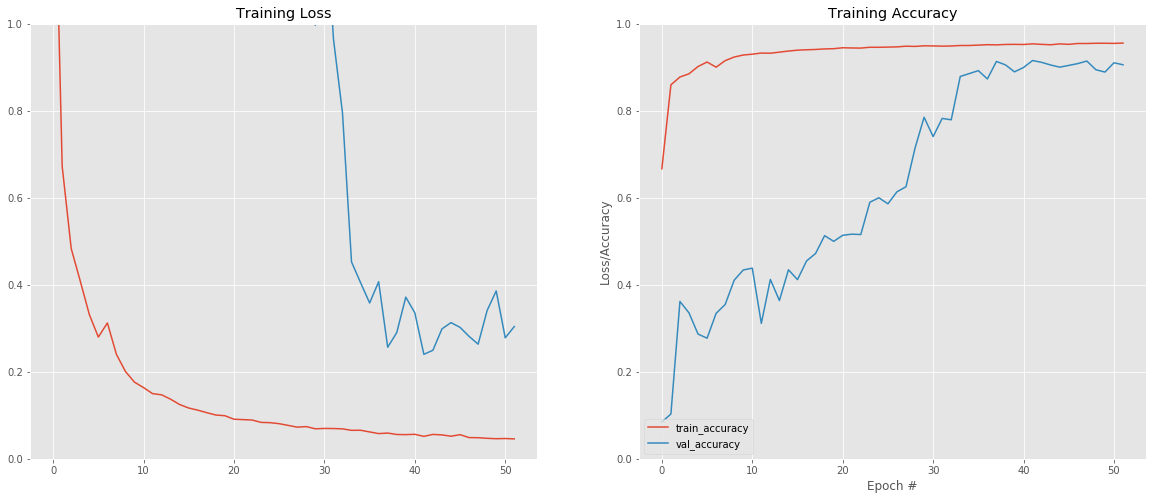

In [34]:
# Get actual number of epochs model was trained for
N = len(result.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
plt.ylim(0, 1)

fig.add_subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(np.arange(0, N), result.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), result.history["val_accuracy"], label="val_accuracy")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [35]:
#training_gen = TrainAugmentGenerator()
testing_gen = ValAugmentGenerator()

### Extract and display model frame, prediction and mask batch

In [36]:

batch_img,batch_mask = next(testing_gen)
pred_all= model.predict(batch_img)
np.shape(pred_all)


Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


(5, 256, 256, 32)

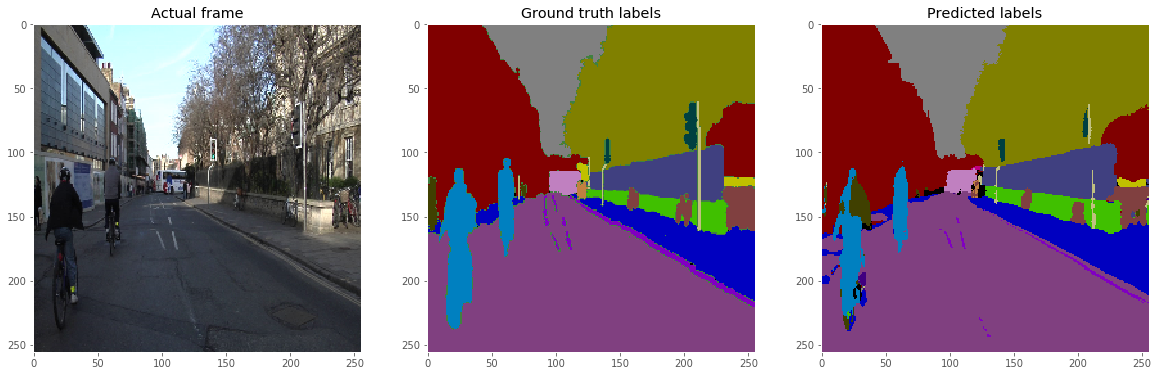

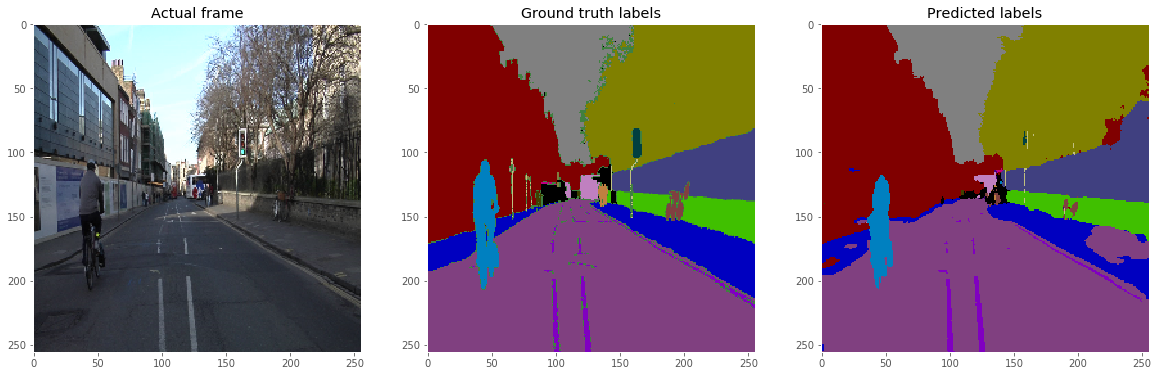

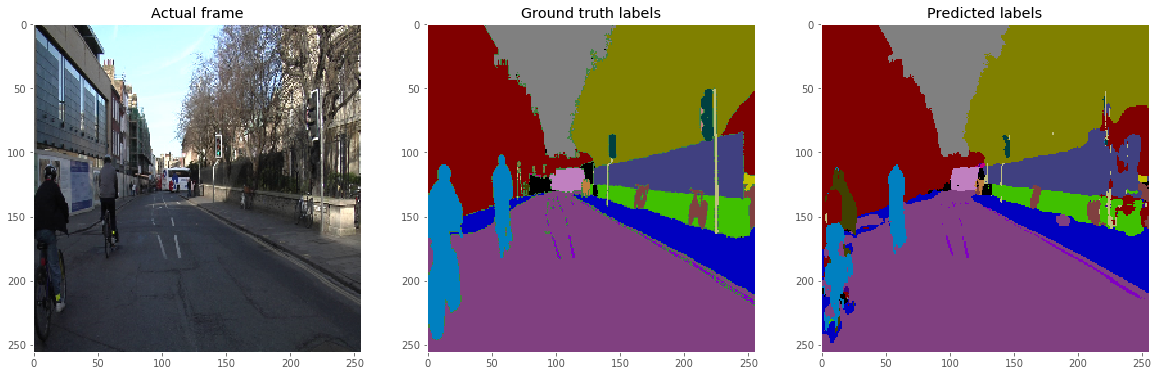

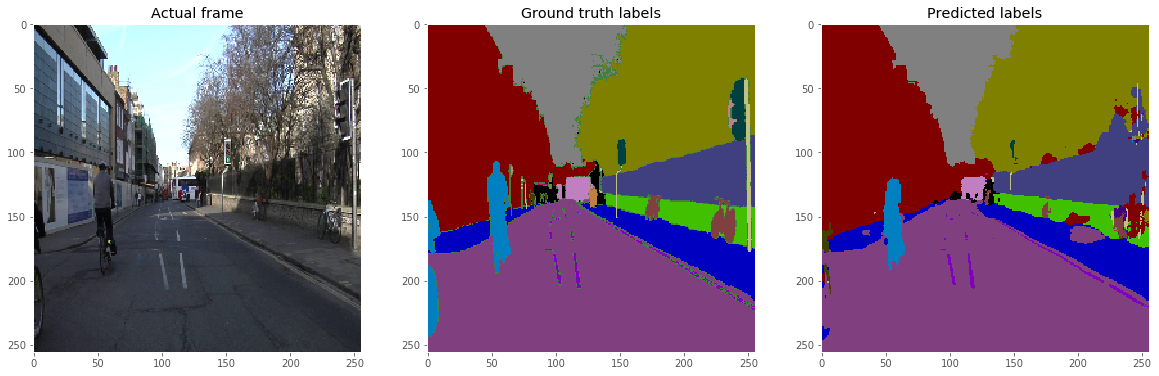

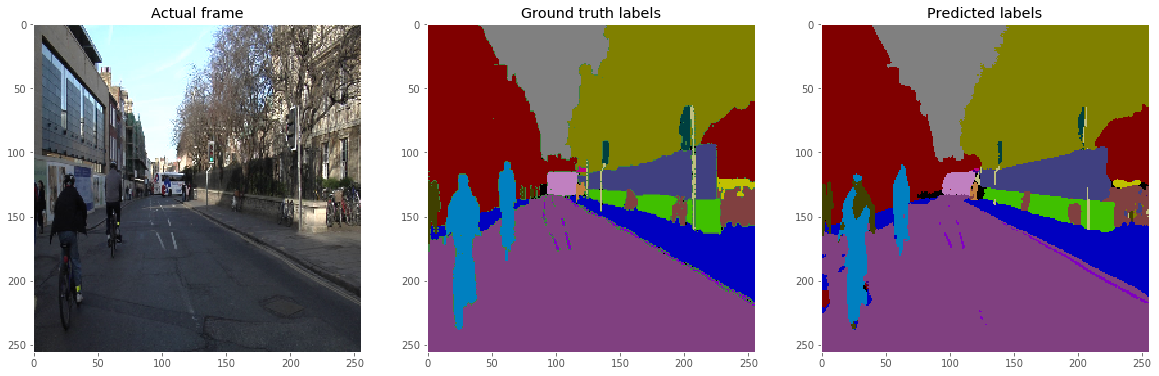

In [37]:
for i in range(0,np.shape(pred_all)[0]):
    
    fig = plt.figure(figsize=(20,8))
    
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(batch_img[i])
    ax1.title.set_text('Actual frame')
    ax1.grid(b=None)
    
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground truth labels')
    ax2.imshow(onehot_to_rgb(batch_mask[i],id2code))
    ax2.grid(b=None)
    
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted labels')
    ax3.imshow(onehot_to_rgb(pred_all[i],id2code))
    ax3.grid(b=None)
    
    plt.show()